In [23]:
# TODO remove
import sys
sys.path.append('/Applications/BayesDB-bayes0.1.dev20150727-262-g5df8e0c.app/Contents/MacOS/venv/lib/python2.7/site-packages')

# --- The APIs that are being highlighed ---

# the main API for loading / saving tables, running BQL queries, returns cursor objects
import bayeslite

# pretty printing tables to screen (can take cursors as input)
import bayeslite.shell.pretty as pretty

# plotting
from bdbcontrib import plotutils
# TODO once fsaad is done use instead: from bdbcontrib import contrib_plot
# importing contrib_plot currently fails with 'No current shell!' error.

# ipython notebook will generate plots inline given a fig object.
import matplotlib.pyplot as plt
%matplotlib inline

# other utilities
from bdbcontrib import general_utils # conttains???
from bdbcontrib import bql_utils  # contains cursor_to_df
# TODO once fsaad is done use instead: from bdbcontrib import contrib_util
# importing general_utils currently fails with 'No current shell!' error.

Introduction
=====
In this example we will explore the core functionality of BayesDB by using BayesDB to explore and analyze some real data. The data we will use is the Union of Concerned Scientists' Satellites data. The data is a catalogue of satellites. Each row of the data represents a satellite and each column is a feature of that satellite such as dry mass, orbit type, launch date, perigee, etc.

Loading the Bayesian Database
=====
The first thing to do is to open our Bayesian database that contains the Bayesian model of the satellites data. This database resides on disk in the form of a `.bdb` file.

In [24]:
satellites_bdb = bayeslite.bayesdb_open("satellites.bdb")

This database contains one table, named `satellites`. We also associate the Bayesian data model with the original raw data, which are in csv format with a header containing the column names.

In [25]:
bayeslite.bayesdb_read_csv_file(satellites_bdb, "satellites", "satellites.utf8.csv", 
                                header=True, create=True, ifnotexists=True)

Before you can use BQL modelling for your data, you must use register a metamodel, such as the Crosscat metamodel with which the `.bdb` file was built.

In [26]:
import crosscat.LocalEngine
import bayeslite.crosscat
crosscat_engine = crosscat.LocalEngine.LocalEngine(seed=0)
crosscat_metamodel = bayeslite.crosscat.CrosscatMetamodel(crosscat_engine)
bayeslite.bayesdb_register_metamodel(satellites_bdb, crosscat_metamodel)

We also register a generator that uses heuristics to guess the types of columns.

In [27]:
generator = bayeslite.guess.bayesdb_guess_generator(satellites_bdb, 'satellites_cc', 'satellites', 'crosscat', 
                                                    ifnotexists=True)

TODO We can see how well the system guess the types of our columns by using the `.describe command.

Standard Database Functionality
====
We can use a SQLite command to list the columns in the table. We easily convert the output into a Pandas dataframe.

In [28]:
pretty.pp_cursor(sys.stdout, satellites_bdb.sql_execute('PRAGMA table_info(satellites)'))

cid |                         name |    type | notnull | dflt_value | pk
----+------------------------------+---------+---------+------------+---
  0 |                         Name | NUMERIC |       0 |       None |  0
  1 |          Country_of_Operator | NUMERIC |       0 |       None |  0
  2 |               Operator_Owner | NUMERIC |       0 |       None |  0
  3 |                        Users | NUMERIC |       0 |       None |  0
  4 |                      Purpose | NUMERIC |       0 |       None |  0
  5 |               Class_of_Orbit | NUMERIC |       0 |       None |  0
  6 |                Type_of_Orbit | NUMERIC |       0 |       None |  0
  7 |                   Perigee_km | NUMERIC |       0 |       None |  0
  8 |                    Apogee_km | NUMERIC |       0 |       None |  0
  9 |                 Eccentricity | NUMERIC |       0 |       None |  0
 10 |               Period_minutes | NUMERIC |       0 |       None |  0
 11 |               Launch_Mass_kg | NUMERIC |     

We can select data just as we would in SQL in BQL:

In [29]:
pretty.pp_cursor(sys.stdout, satellites_bdb.execute(
        'SELECT name, dry_mass_kg, period_minutes, class_of_orbit FROM satellites LIMIT 10;'))
# TODO beautify

                                                   Name | Dry_Mass_kg | Period_minutes | Class_of_Orbit
--------------------------------------------------------+-------------+----------------+---------------
                                               AAUSat-3 |        None |         100.42 |            LEO
          ABS-1 (LMI-1, Lockheed Martin-Intersputnik-1) |        1730 |        1436.08 |            GEO
               ABS-1A (Koreasat 2, Mugunghwa 2, ABS-1A) |         800 |        1436.13 |            GEO
ABS-2i (MBSat, Mobile Broadcasting Satellite, Han Byul) |        1700 |         1436.1 |            GEO
                        ABS-7 (Koreasat 3, Mugungwha 3) |        1800 |        1436.06 |            GEO
 AcrimSat (Active Cavity Radiometer Irradiance Monitor) |          13 |           98.6 |            LEO
                     Advanced Orion 2 (NROL 6, USA 139) |        None |        1436.14 |            GEO
                    Advanced Orion 3 (NROL 19, USA 171) |       

Visualizing the Data
=====

We can also use visualization tools packaged with BayesDB. In the next example, the first argument `dry_mass_kg` is a `NUMERICAL` variable and its conditional distribution is plotted for each value of the categorical variable `class_of_orbit`, alongside the marginal distributions.

Dry_Mass_kg | Class_of_Orbit
------------+---------------
       None |            LEO
       1730 |            GEO
        800 |            GEO
       1700 |            GEO
       1800 |            GEO
         13 |            LEO
       None |            GEO
       None |            GEO
       None |            GEO
       None |            GEO


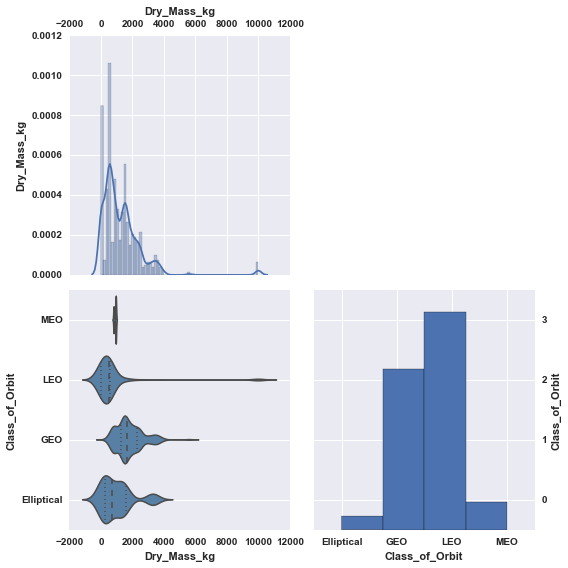

In [32]:
# print some of the data before it gets plotted
pretty.pp_cursor(sys.stdout, satellites_bdb.execute(
        'SELECT dry_mass_kg, class_of_orbit FROM satellites LIMIT 10'))

# TODO once fsaad is done, we won't need the dataframe
# (the plotting will take the BQL command itself)
df = bql_utils.cursor_to_df(satellites_bdb.execute(
        'SELECT dry_mass_kg, class_of_orbit FROM satellites'))
c = len(df.columns)*4
fig = plt.figure(tight_layout=True, figsize=(c, c))
gs = plotutils.pairplot(df, bdb=satellites_bdb, generator_name='satellites_cc',
                        use_shortname=None, show_contour=False,
                        colorby=None, show_missing=True, show_full=False)
plt.show()

Inferring Missing Data
=====
Inferring is like imputing. `INFER` produces a summary value for a missing (`NULL`) entry. If we use the `EXPLICIT` keyword, we can re-infer present values.

Finally, we need to tell BayesDB which values to treat as missing, `NULL`. Different datasets use different markers for missing data, this dataset uses `NaN`. To convert all instances of `NaN` to SQL `NULL`, we use the `nullify` utility, followed by the table, followed by the value to convert to `NULL`.

In [36]:
# TODO replace bql_utils with contrib_utils once fsaad is done
print 'total number of rows', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites;'))
print 'before nullify'
print 'NULL count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;'))
print 'NaN count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NaN;'))
general_utils.nullify(satellites_bdb, 'satellites', float('NaN'))
print 'after nullify'
print 'NULL count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;'))
print 'NaN count', bql_utils.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NaN;'))
# TODO strage... need to debug this.

total number of rows    "COUNT"(*)
0        7002
before nullify
NULL count    "COUNT"(*)
0         646
NaN count    "COUNT"(*)
0        3230
after nullify
NULL count    "COUNT"(*)
0         646
NaN count    "COUNT"(*)
0        3230


First we will impute missing values of `type_of_orbit`. Let us see how many values are missing.

BELOW IN PROGRESS

In [37]:
print bu.cursor_to_df(satellites_bdb.execute('SELECT COUNT(*) FROM satellites WHERE type_of_orbit IS NULL;'))

NameError: name 'bu' is not defined

In [ ]:



import bayeslite.guess
import bayeslite.crosscat
import crosscat
import crosscat.LocalEngine
from bdbcontrib.facade import do_query
from bdbcontrib import plotutils
from bdbcontrib import general_utils
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# TODO: content taken from http://probcomp-4.csail.mit.edu/bayeslite/tutorials/satellites/satellites.bql

Notice that `NaN` entires have been replaced with `None`, which is the way Python represents SQL `NULL`.

In [ ]:
c = len(df.columns)*4

fig = plt.figure(tight_layout=True, figsize=(c, c))
gs = plotutils.pairplot(df, bdb=satellites_bdb, generator_name='satellites_cc',
                        use_shortname=None, show_contour=False,
                        colorby=None, show_missing=True, show_full=False)
plt.close('all')
# use plt.show() to open a separate window where you won't get a warning about tight_layout, 
# and you will have larger plots to look at.
fig

In [ ]:
for row in satellites_bdb.execute("SELECT Name, dry_mass_kg FROM satellites LIMIT 10;"):
    print row